# The lapidarist problem (Predictive modeling)
As I mentioned during the problem exploration and data preprocessing module I planned to use a MLR as benchmark model. However, when testing the linearity of the problem with respect to its target variable I noticed that it seems that for some key features (carat, and dimensions) there existed a correlation but not a linear one, therefore, I wanted to try a polynomial regression to see if a polynomial model worked better, the results will be explained later in the notebook. 

After determining which is going to be my benchmark model, I'll proceed to use the coefficients of the winning model to know if there's worth in applying feature engineering or if a normal non linear model such as SVR might worked better to predict the price of the diamond. 


In [112]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.svm import SVR
import joblib


data = pd.read_csv('Data/preprocessed_data.csv')

## Train test split
I decided to use a set partition of 30% as the dataset is big enough to train with 70% of the data only without missing to learn key patterns.

In [113]:
# Train-test split
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## MLR model vs Polynomial model
I'm comparing a MLR model vs a Ridge regression model vs a Polynomial regression model. The polynomial degree selected after some test was 3, this means that the data points follow a cubic relationship better than a quadratic or linear, the application of polynomial features allos the model to capture more complex relationships by capturing the combined effect of multiple features on the target variable. 

### Training the models

In [114]:
# Train the MLR model
MLR_model = LinearRegression()
MLR_model.fit(X_train, y_train)
MLR_predictions = MLR_model.predict(X_test)
MLR_residuals = y_test - MLR_predictions

# Train Ridge regression models
ridge_model = Ridge(alpha= 10)  
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_residuals = y_test - ridge_predictions

# Train the polynomial regression model
# Apply polynomial transformations
poly_trans = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly_trans.fit_transform(X_train)
X_poly_test = poly_trans.transform(X_test)

# Train a polynomial regression
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_predictions = poly_model.predict(X_poly_test)
poly_residuals = y_test - poly_predictions

### Evaluating the predictive power
After evaluating the model we can see that the linear regression with polynomial features of third degree performs signifcantly better than both MLR and Ridge regression. In terms of RMSE the polynomial regression outperforms significantly the linear and ridge regression, while the polynomial model also improves in R2 with 97% of the variability of the model explained. 

In [115]:
# Evaluate the performance of the mdoels
rmse_linear = mean_squared_error(y_test, MLR_predictions, squared=False)
r2_linear = r2_score(y_test, MLR_predictions)

rmse_ridge = mean_squared_error(y_test, ridge_predictions, squared=False)
r2_ridge = r2_score(y_test, ridge_predictions)

rmse_poly = mean_squared_error(y_test, poly_predictions, squared=False)
r2_poly = r2_score(y_test, poly_predictions)

# Display performance metrics
print(f'Linear Regression RMSE: {rmse_linear:.2f}, R²: {r2_linear * 100:.2f}%')
print(f'Ridge Regression RMSE: {rmse_ridge:.2f}, R²: {r2_ridge * 100:.2f}%')
print(f'Polynomial Regression RMSE: {rmse_poly:.2f}, R²: {r2_poly * 100:.2f}%')


Linear Regression RMSE: 1178.96, R²: 91.00%
Ridge Regression RMSE: 1180.24, R²: 90.98%
Polynomial Regression RMSE: 632.41, R²: 97.41%


c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


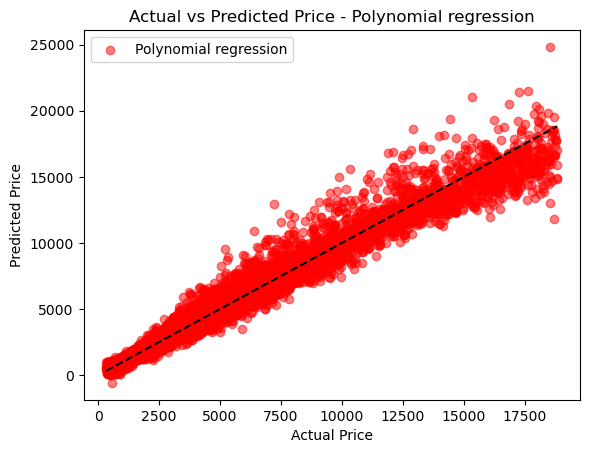

In [116]:
# Ploting the results on the test set
plt.scatter(y_test, poly_predictions, alpha=0.5, color='r', label='Polynomial regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price - Polynomial regression')
plt.legend()
plt.show()

### Making sure the model is not overfitted
However, the RMSE & R-squared are not only the only metrics we should be tracking. Ploting learning curves will allows to find the balance between the predictive power ensuring we have not overfitted the model. Basically, we look for the learning curves for the training and validation error to converge. 

In the learning curve the X axis represnts the samples used to train the model while the y axis is the RMSE of the model, the color of the line just indicates if the error is upon the training set or the CV scores, that is why it is importante to find convergence because it indicates us that the model fits well to new unseen data. The function in respect to the second function can be explaind as the size increases the validation error converges to the trainning error indicating that the overfitting is decreasing, around the 25Kth training samples the model reaches a point in which additional trainning samples do not improve the performance. 

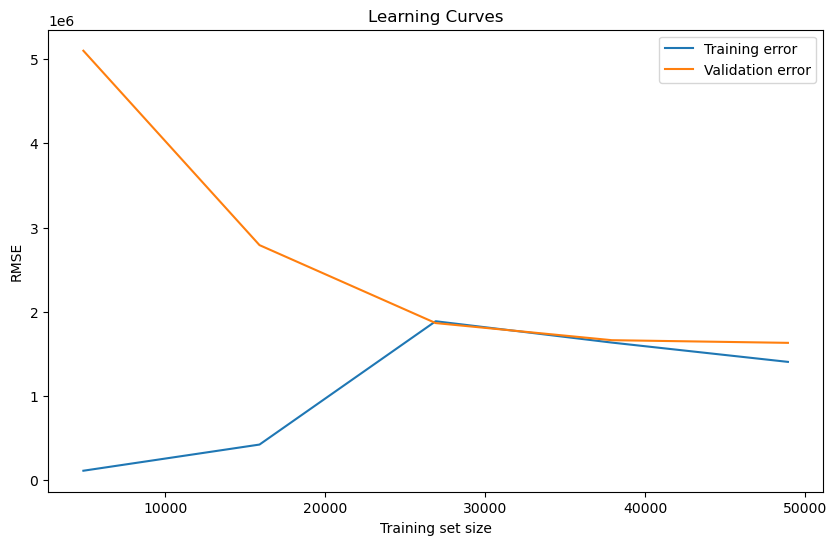

In [117]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(poly_model, X, y, cv=25, scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.title('Learning Curves')
plt.legend()
plt.show()

### Residuals analysis
The residuals shows a distribution that is not perfectly normal confirmed by a Shapiro-Wilk test of W=0.9057 and a p-value of 0. Even when p-value is not deterministic for big models such as ours it is important to do some further adjustment to the model in order to infere the correct conclusions. 

Even when the chosen model is a polynomial one (chosen upon the big reduction in rmse) in terms of coefficient the polynomial regression is still a linear one so having a normally distributed residuals is still a model assumption to achieve. Non-normal residuals can be infered that our model may not be capturing all the patterns in the data and there might be some sort of structure in the residuals that has not been explained or that there's correlation in the residuals which can reduce the predictive power of the model and lead to biased estimates. 

The results on the residuals gives us a lead on where to go with the model. I am going to follow up a three step analysis to address possible reasons on why the model (even when performing relatevliy well) has issues in the residuals, the process being: 
- Checking multicollinearity
- Feature engeneering
- Model refinement

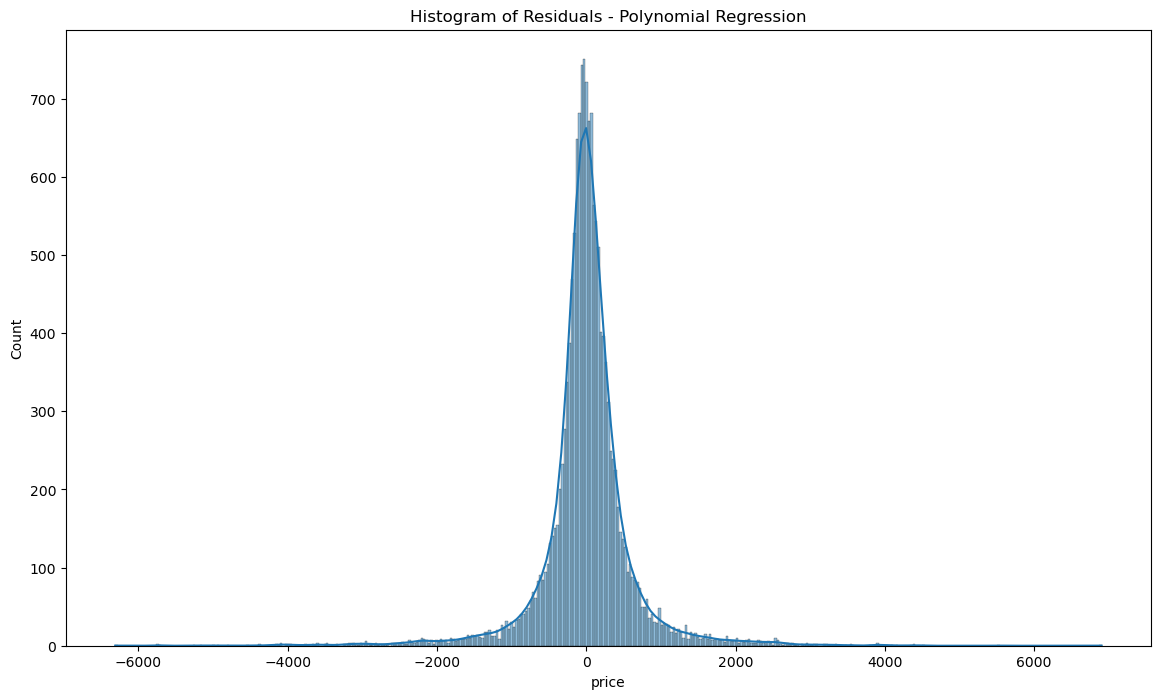

In [118]:
# Plot residuals for Polynomial Regression
plt.figure(figsize=(14, 8))
sns.histplot(poly_residuals, kde=True)
plt.title('Histogram of Residuals - Polynomial Regression')
plt.show()


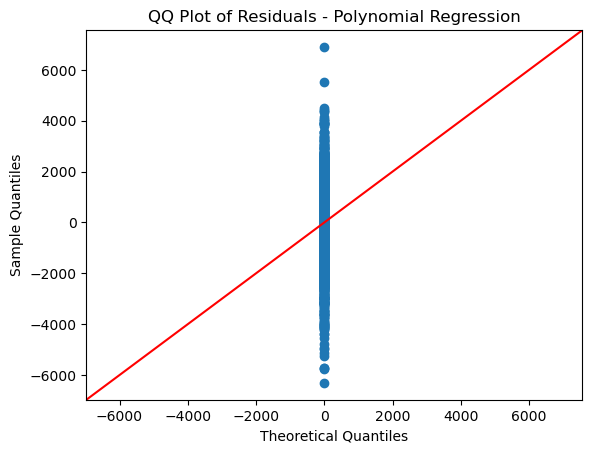

Shapiro-Wilk Test for Polynomial Regression Residuals: W=0.8086, p-value=0.0000


c:\Users\rafae\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [119]:
# QQ Plot
sm.qqplot(poly_residuals, line='45')
plt.title('QQ Plot of Residuals - Polynomial Regression')
plt.show()

# Shapiro-Wilk Test for normality
shapiro_test_poly = stats.shapiro(poly_residuals)
print(f'Shapiro-Wilk Test for Polynomial Regression Residuals: W={shapiro_test_poly[0]:.4f}, p-value={shapiro_test_poly[1]:.4f}')

## WLS Regression
As there are signs of heterosedasticity, I am going to apply a Weighted Least Square Regression. This regressgion techniqute assings a weight based on the inverse of its variance to each observation so each observation with larger variance is penalized and the ones with smaller variances get larger weights. 

c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Polynomial Regression RMSE: 632.41, R²: 97.41%
WLS Polynomial Regression RMSE: 633.06, R²: 97.40%


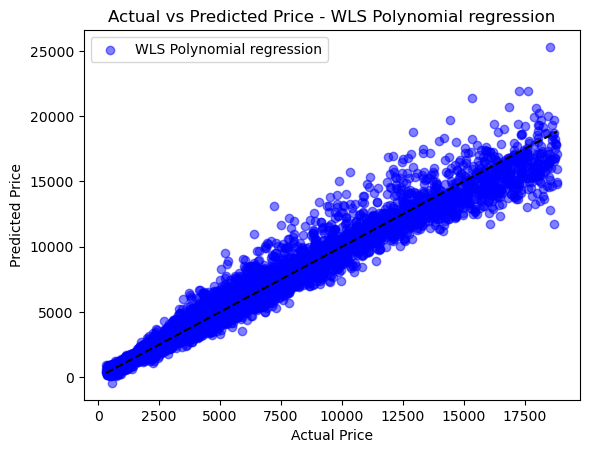

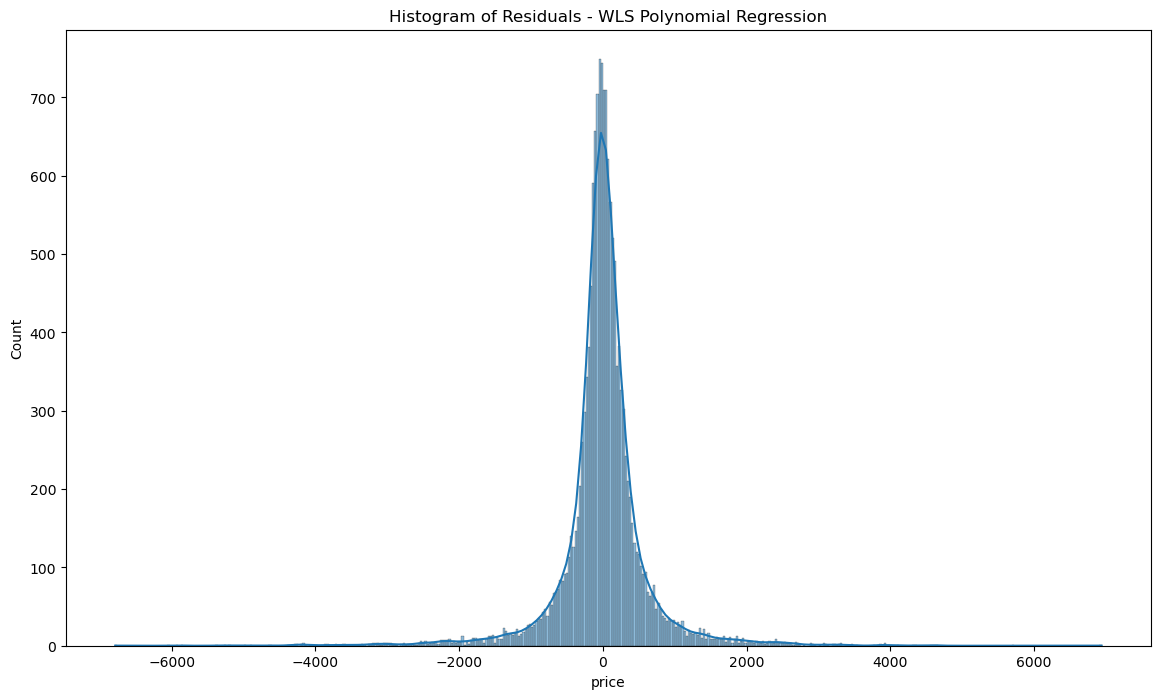

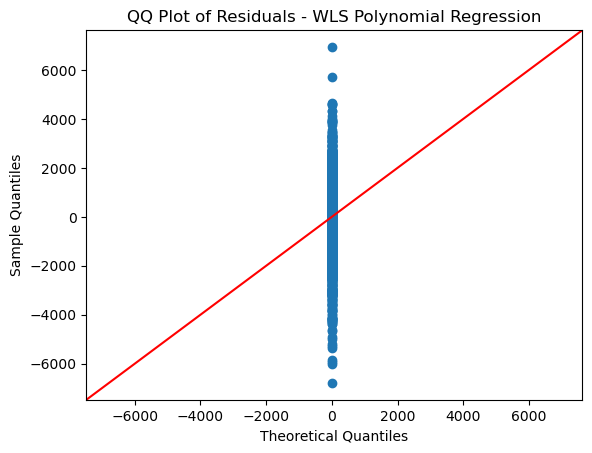

Shapiro-Wilk Test for WLS Polynomial Regression Residuals: W=0.7949, p-value=0.0000


c:\Users\rafae\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [120]:
# Apply OLS
# Estimate the weights
poly_train_predictions = poly_model.predict(X_poly_train)
poly_train_residuals = y_train - poly_train_predictions
weights = 1 / np.sqrt(np.abs(poly_train_residuals)) # Estimate the variance of residuals of the trainning sub set and compute weights

# Fit the WLS model using the weights
X_poly_train = sm.add_constant(X_poly_train)
X_poly_test = sm.add_constant(X_poly_test)

wls_model = sm.WLS(y_train, X_poly_train, weights=weights[:len(y_train)]).fit()
wls_predictions = wls_model.predict(X_poly_test)

# Evaluate the performance of the WLS model
rmse_wls = mean_squared_error(y_test, wls_predictions, squared=False)
r2_wls = r2_score(y_test, wls_predictions)

# Display performance metrics
print(f'Polynomial Regression RMSE: {rmse_poly:.2f}, R²: {r2_poly * 100:.2f}%')
print(f'WLS Polynomial Regression RMSE: {rmse_wls:.2f}, R²: {r2_wls * 100:.2f}%')

# Plotting the results on the test set
plt.scatter(y_test, wls_predictions, alpha=0.5, color='b', label='WLS Polynomial regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price - WLS Polynomial regression')
plt.legend()
plt.show()

# Plot residuals for WLS Polynomial Regression
wls_residuals = y_test - wls_predictions

plt.figure(figsize=(14, 8))
sns.histplot(wls_residuals, kde=True)
plt.title('Histogram of Residuals - WLS Polynomial Regression')
plt.show()

# QQ Plot
sm.qqplot(wls_residuals, line='45')
plt.title('QQ Plot of Residuals - WLS Polynomial Regression')
plt.show()

# Shapiro-Wilk Test for normality
shapiro_test_wls = stats.shapiro(wls_residuals)
print(f'Shapiro-Wilk Test for WLS Polynomial Regression Residuals: W={shapiro_test_wls[0]:.4f}, p-value={shapiro_test_wls[1]:.4f}')

## SVR
As there was no effect using WLS regression I will move to non linear models, non linear models unlike linear models do not have normallity and homoscedasiticity as part of their model assumptions, so the residual analysis does not strictly apply in the same way. 

After some tries with different type of kernels and hyperparamters I estimate the best solution using SVC is a polynomial kernel of degree 3 and a regularization parameter of C = 5. However, even when SVR performs better than the linear regression, ridge regression and WLS regression is still does not outperform (and categorically) the performance of the polynomial regression of degree 3, even when (a priori) SVR should be betterr capturing more complex non linear patterns in the data. 

c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SVR: RMSE: 821.98, R²: 95.63%
Polynomial Regression RMSE: 632.41, R²: 97.41%


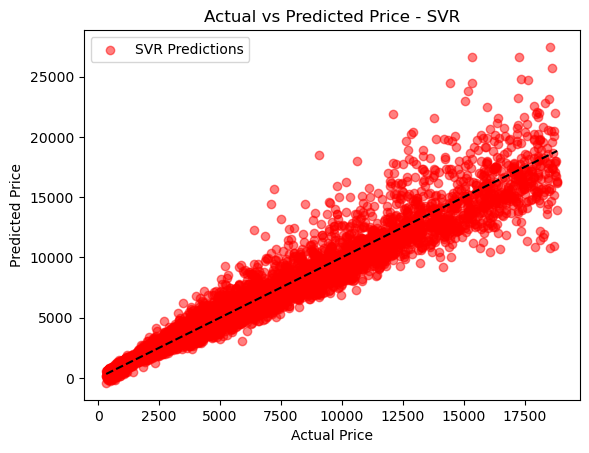

In [121]:
# SVR model
svr_model = SVR(kernel='poly', degree=3, 
                gamma='scale', 
                C = 5)

svr_model.fit(X_train, y_train)

svr_predictions = svr_model.predict(X_test)
svr_residuals = y_test - svr_predictions

# Evaluate the performance of the mdoels
rmse_svr = mean_squared_error(y_test, svr_predictions, squared=False)
r2_svr = r2_score(y_test, svr_predictions)

# Display performance metrics
print(f'SVR: RMSE: {rmse_svr:.2f}, R²: {r2_svr * 100:.2f}%')
print(f'Polynomial Regression RMSE: {rmse_poly:.2f}, R²: {r2_poly * 100:.2f}%')

# Ploting the results on the test set
plt.scatter(y_test, svr_predictions, alpha=0.5, color='r', label='SVR Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price - SVR')
plt.legend()
plt.show()



## Model comparison


In [122]:
# Model comparison
implemented_model = ['Linear Regression', 'Ridge Regression', 'Polynomial Regression',
                     'Weighted Least Squares Regression', 'SVR']

RMSE = [rmse_linear, rmse_ridge, rmse_poly, rmse_wls, rmse_svr]

RSquared = [r2_linear, r2_ridge, r2_poly, r2_wls, r2_svr]

performance_data = {
    'Model': implemented_model,
    'RMSE': RMSE,
    'R-squared': RSquared
}

Performance_table = pd.DataFrame(performance_data)

print(tabulate(Performance_table, headers='keys', tablefmt='pretty', showindex=False))


+-----------------------------------+--------------------+--------------------+
|               Model               |        RMSE        |     R-squared      |
+-----------------------------------+--------------------+--------------------+
|         Linear Regression         | 1178.961144464291  | 0.9099998044322022 |
|         Ridge Regression          | 1180.2377793772805 | 0.9098047859609933 |
|       Polynomial Regression       | 632.4082818918341  | 0.9741035897567283 |
| Weighted Least Squares Regression | 633.0623062190339  | 0.9740499989336212 |
|                SVR                | 821.9801837502314  | 0.9562510973228121 |
+-----------------------------------+--------------------+--------------------+


## Saving the model for later deployment

In [124]:
# Save the model and transformer
joblib.dump(poly_model, 'Models/poly_model.pkl')
joblib.dump(poly_trans, 'Models/poly_transformer.pkl')

['Models/poly_transformer.pkl']